In [2]:
import os
import sys
sys.path.append("../..")
import numpy as np
import torch
import torch.utils.data as data
import matplotlib.pyplot as plt
from PIL import Image
from custom_dataset.raw_dataset import CollectedGlyphDataset
from custom_dataset.utils.helper import general_collate_fn

from transformers import SamModel, SamProcessor

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    # mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=1))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

gpu_id = 7
ckpt_dir = "/blob/proj/poster_gen/tools/work_dirs/sam/sam_sft_prodigy_bs1_lr1_res1024_enc_dec_bloss/checkpoint-final"

processor = SamProcessor.from_pretrained("facebook/sam-vit-huge", cache_dir="/blob/pretrained/sam")
if ckpt_dir is None:
    model = SamModel.from_pretrained("facebook/sam-vit-huge", cache_dir="/blob/pretrained/sam").to(torch.device("cuda", index=gpu_id))
else:
    model = SamModel.from_pretrained(ckpt_dir).to(torch.device("cuda", index=gpu_id))

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_cfg = dict(
    resolution=256,
    data_root="/blob/data/JPoster/",
    asset_root="/blob/proj/poster_gen/assets",
    std_font_path="/blob/data/all_fonts/NotoSansSC-Regular.ttf",
    expand_ratio=0.2,
)
dataset = CollectedGlyphDataset(
    datype="val",
    **dataset_cfg,
)
dataloader = data.DataLoader(
    dataset, 
    batch_size=1, 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True,
    collate_fn=general_collate_fn,
)

[[8, 11, 44, 68], [48, 11, 82, 68], [87, 11, 120, 69]]


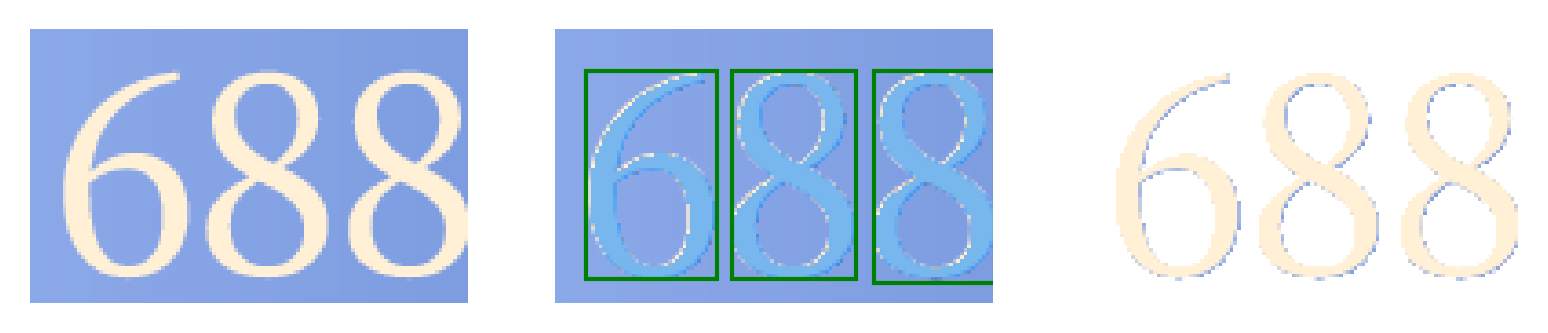

[[4, 16, 69, 72], [69, 12, 136, 71]]


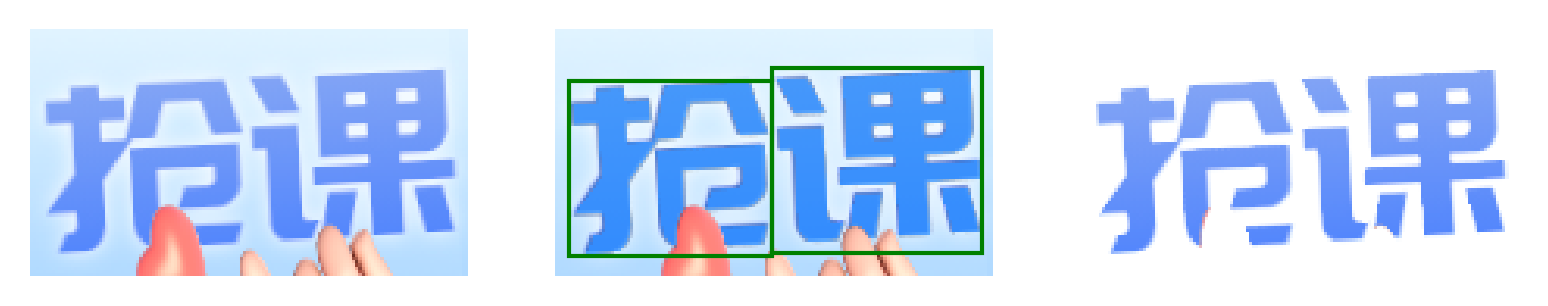

[[17, 8, 42, 48], [53, 9, 75, 47], [84, 3, 130, 51], [140, 4, 187, 51], [195, 3, 241, 51]]


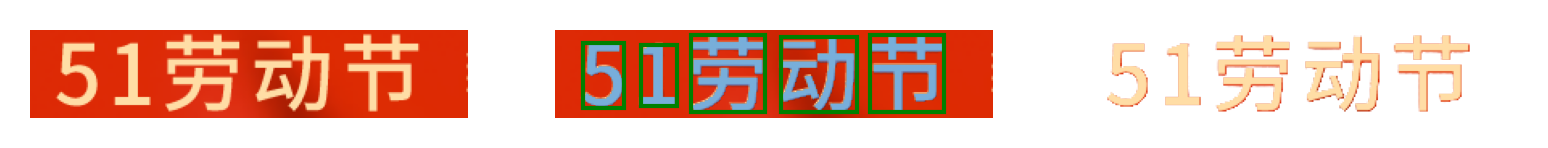

[[20, 2, 54, 60], [58, 3, 92, 61], [96, 2, 132, 60]]


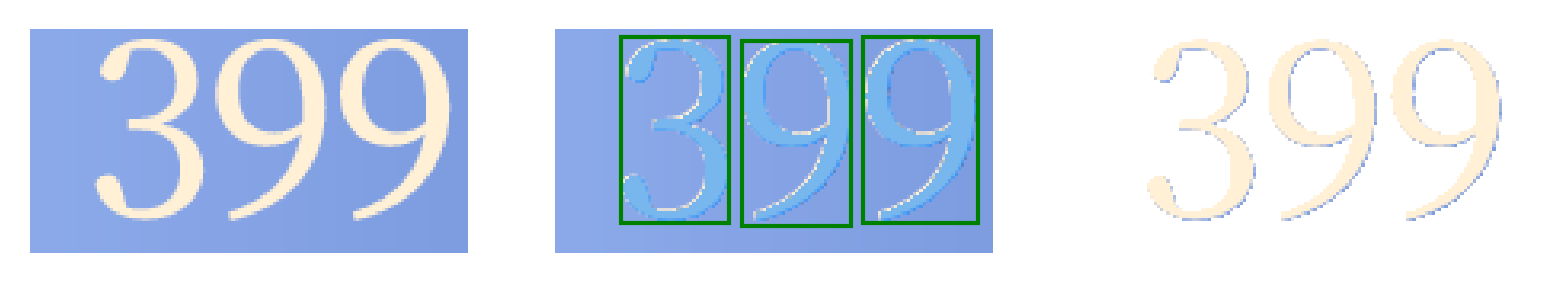

[[74, 28, 167, 122], [165, 28, 262, 121], [261, 26, 352, 121], [352, 28, 447, 121], [73, 136, 166, 231], [168, 136, 255, 229], [263, 136, 353, 230], [353, 137, 448, 229]]


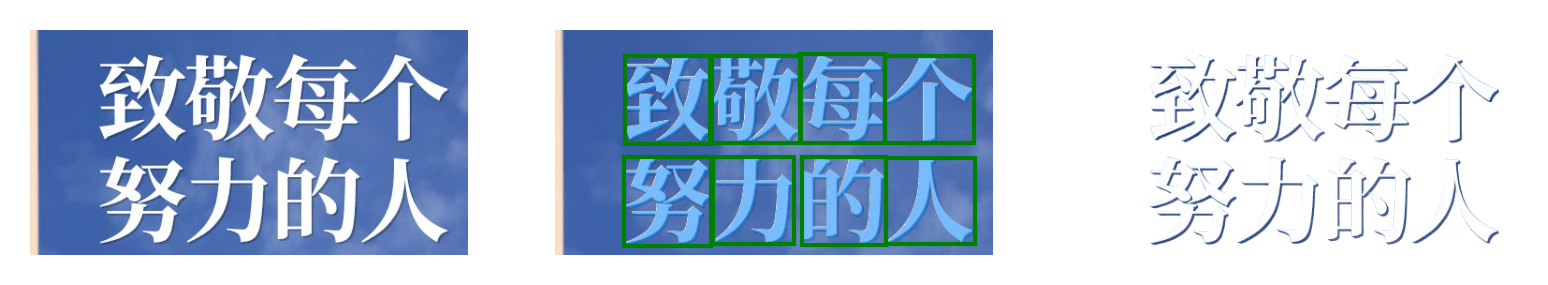

[[77, 14, 172, 116], [183, 14, 285, 117], [293, 15, 394, 114], [401, 22, 448, 108], [76, 127, 130, 180], [132, 130, 184, 180], [186, 127, 240, 180], [243, 129, 296, 180], [301, 127, 352, 180], [356, 130, 409, 180], [410, 127, 464, 180]]


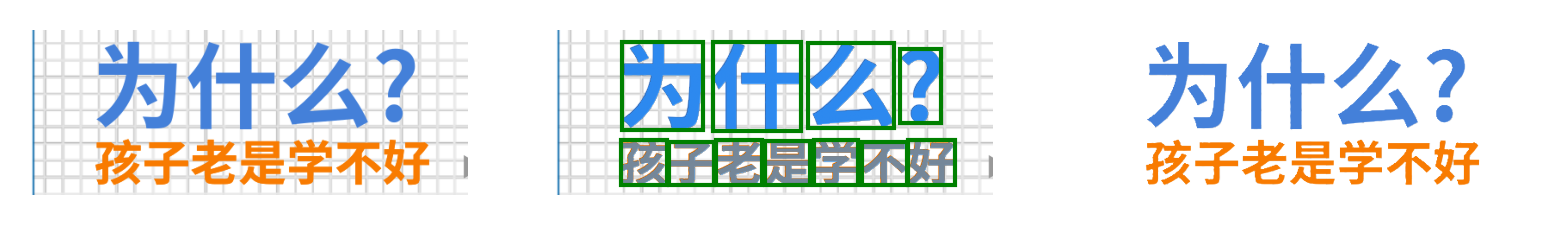

[[53, 5, 108, 76], [114, 6, 164, 75], [170, 6, 220, 76], [232, 5, 277, 74], [83, 84, 137, 154], [139, 84, 195, 155], [201, 85, 251, 155], [257, 83, 312, 154], [316, 85, 370, 152], [374, 84, 426, 154], [432, 86, 484, 154]]


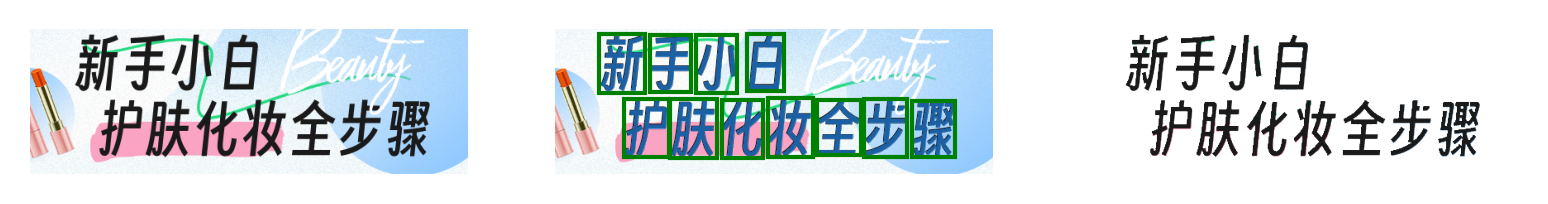

[[35, 8, 58, 37], [58, 8, 81, 37], [81, 7, 105, 36], [112, 8, 136, 37], [136, 8, 159, 37], [159, 8, 183, 37], [184, 8, 206, 37], [34, 41, 58, 71], [59, 40, 82, 71], [82, 41, 106, 71], [112, 41, 136, 71], [135, 41, 159, 71], [159, 41, 183, 70], [184, 42, 206, 71]]


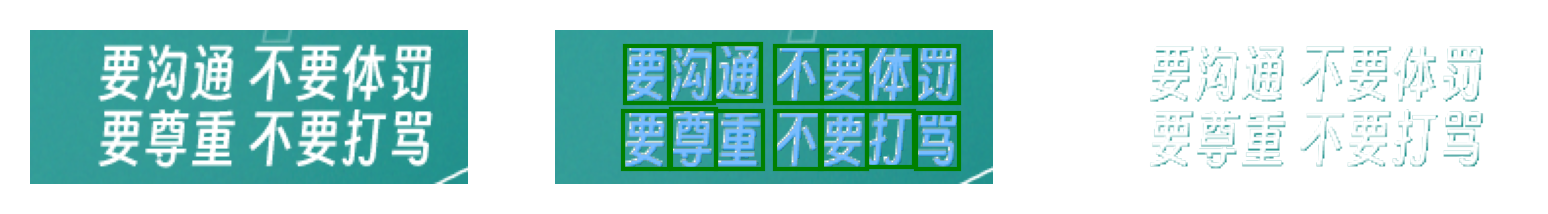

[[35, 0, 62, 28], [65, 2, 91, 28], [95, 0, 121, 28], [126, 5, 152, 26], [155, 1, 182, 28], [185, 1, 212, 28], [215, 1, 242, 28]]


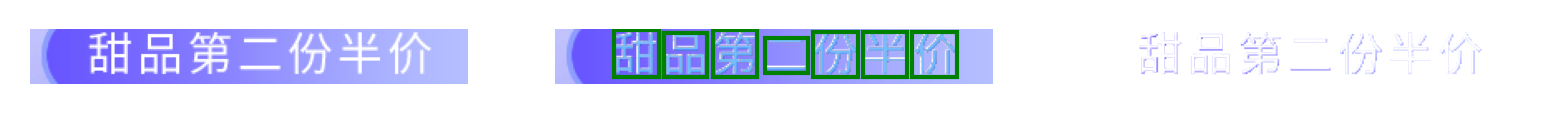

[[17, 9, 191, 135], [171, 11, 348, 133], [330, 7, 505, 133], [492, 5, 667, 131]]


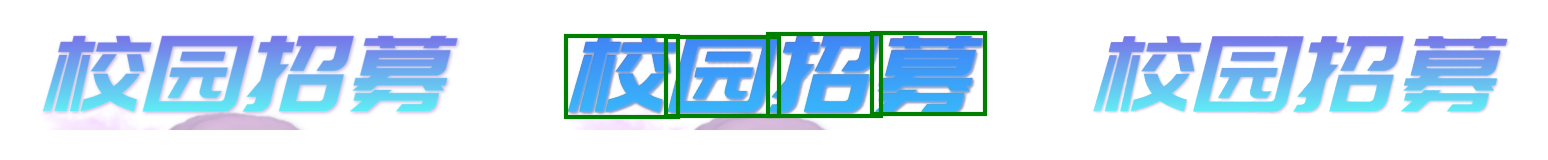

[[3, 8, 100, 171], [107, 42, 193, 184], [201, 87, 298, 183], [304, 87, 403, 184], [408, 87, 506, 183]]


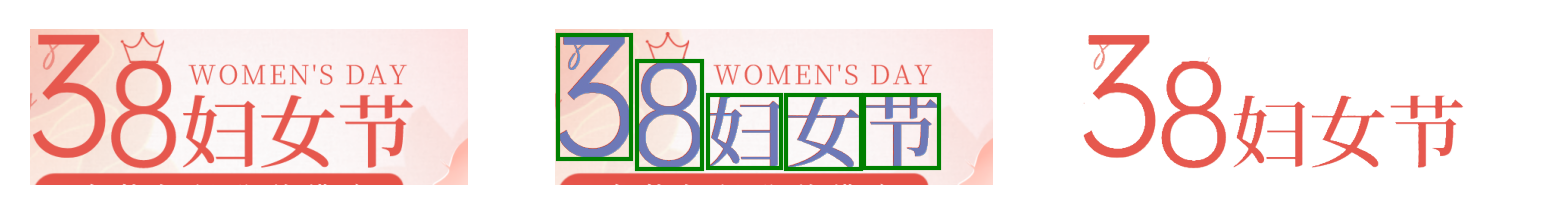

[[20, 15, 57, 75], [66, 16, 105, 76], [114, 14, 156, 76], [167, 10, 241, 84], [263, 10, 325, 83], [348, 10, 421, 85]]


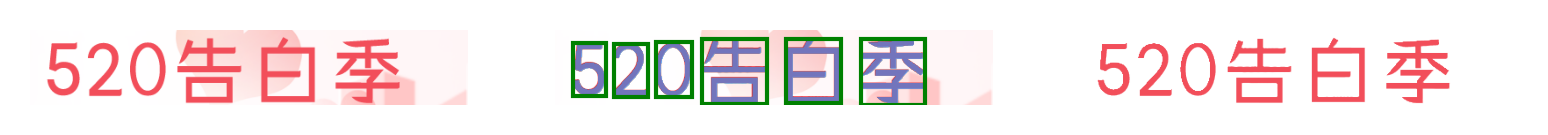

[[34, 9, 69, 46], [73, 1, 108, 47], [112, 33, 128, 47], [134, 3, 164, 46], [171, 1, 205, 46], [210, 1, 258, 47]]


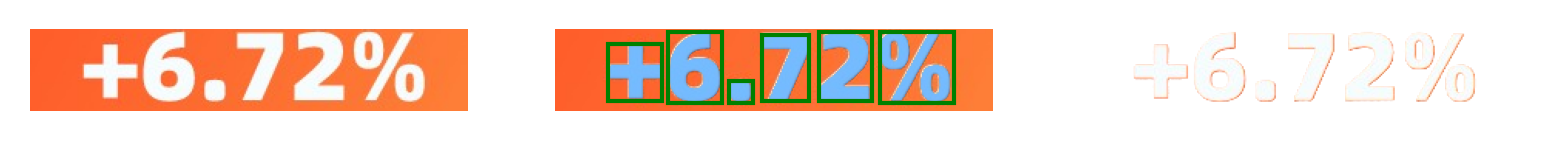

[[46, 9, 98, 61], [104, 11, 156, 63], [161, 9, 214, 62], [218, 15, 247, 58], [254, 14, 282, 58], [288, 15, 317, 58], [322, 13, 375, 62], [379, 10, 432, 63], [436, 15, 465, 58], [471, 15, 500, 58], [506, 14, 558, 62]]


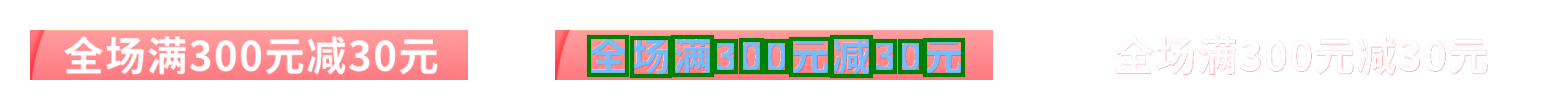

[[29, 9, 87, 69], [497, 9, 555, 68]]


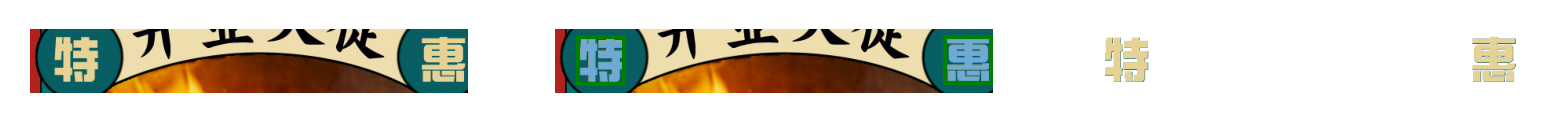

[[28, 5, 159, 164], [173, 42, 291, 161]]


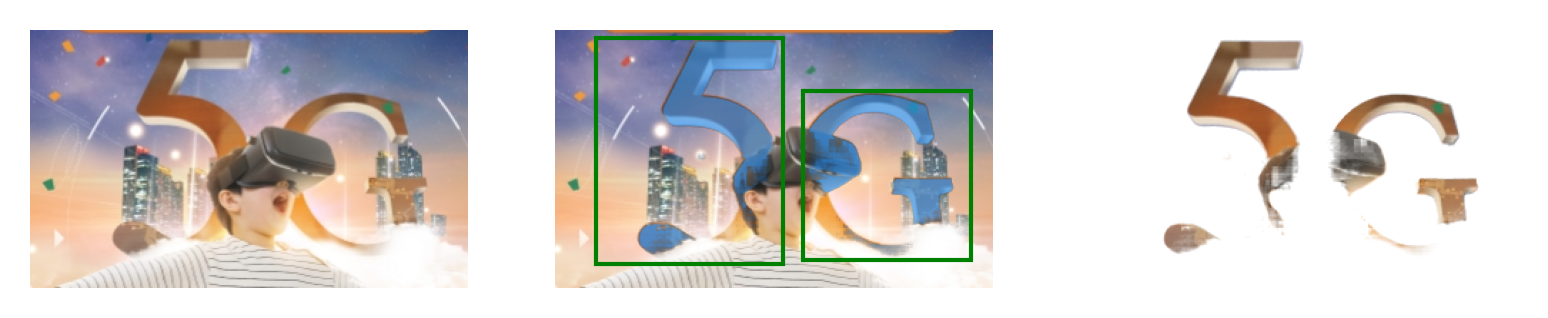

[[28, 51, 46, 76], [54, 11, 96, 74], [103, 12, 148, 74], [157, 33, 184, 62], [186, 33, 215, 61], [216, 33, 245, 61]]


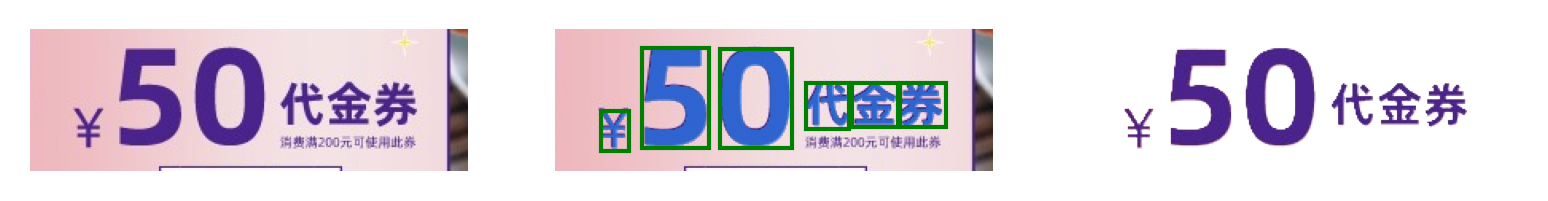

[[12, 9, 31, 52], [39, 8, 65, 53], [68, 8, 95, 53], [94, 48, 101, 53], [110, 28, 126, 53], [133, 37, 141, 55], [140, 37, 158, 53]]


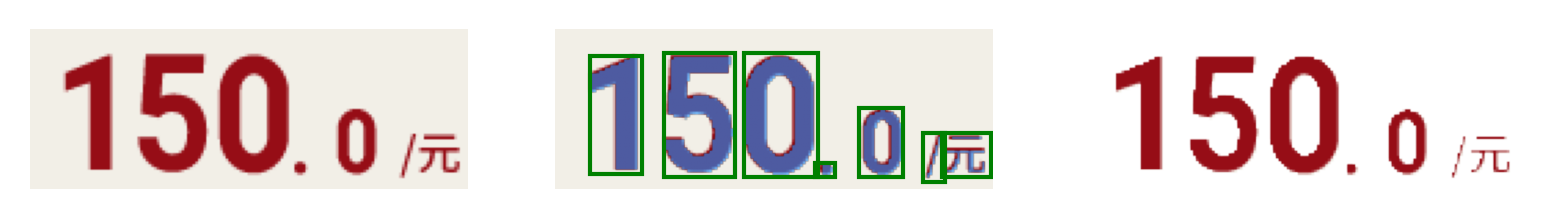

[[38, 14, 70, 89], [69, 7, 163, 95], [153, 8, 248, 95], [239, 7, 332, 95], [323, 8, 418, 95], [416, 14, 449, 89]]


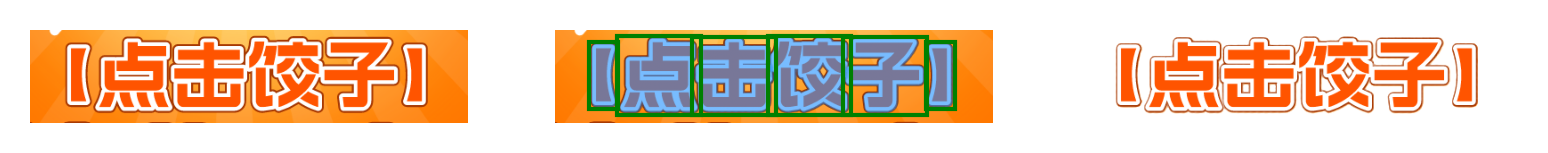

[[80, 98, 165, 210], [162, 99, 233, 196], [220, 79, 278, 174], [271, 61, 337, 151], [316, 37, 392, 132], [68, 199, 171, 315], [151, 193, 186, 281], [180, 202, 213, 269], [205, 169, 258, 256], [240, 144, 311, 243], [288, 123, 361, 223], [343, 115, 416, 208], [393, 98, 448, 212], [445, 71, 491, 173]]


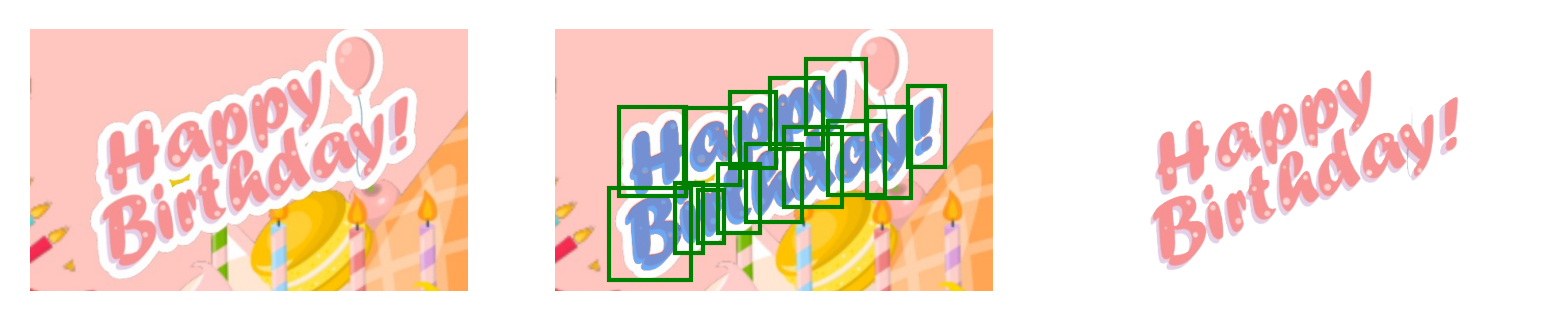

[[27, 0, 56, 28], [54, 3, 82, 32], [80, 7, 110, 35], [106, 10, 136, 39], [133, 14, 163, 42]]


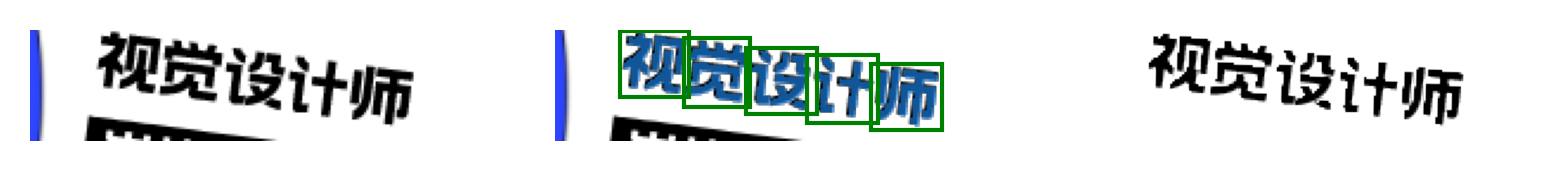

In [8]:
for idx, batch in enumerate(dataloader):
    if idx > 20: break

    crop_img = batch["crop_img"][0].convert("RGB")
    crop_bg = batch["crop_bg"][0]
    seg_bboxs = batch["seg_bboxs"][0]
    print(seg_bboxs)

    # predict mask using sam2
    inputs = processor(crop_img, input_boxes=[seg_bboxs], return_tensors="pt").to(torch.device("cuda", index=gpu_id))
    outputs = model(**inputs, multimask_output=False)
    masks = processor.post_process_masks(
        outputs.pred_masks.cpu(), 
        inputs["original_sizes"].cpu(), 
        inputs["reshaped_input_sizes"].cpu(),
        binarize=False,
    )[0]
    masks = masks.clamp(min=0.0, max=1.0)
    mask = masks.max(dim=0)[0][0]
    mask = mask.detach().cpu().numpy()
    mask = (mask * 255).astype("uint8")

    mask_pil = Image.fromarray(mask)
    crop_img_rgba = Image.merge("RGBA", (*crop_img.split(), mask_pil))

    # draw results
    fig, axes = plt.subplots(1, 3, dpi=300)
    axes[0].imshow(crop_img)
    # axes[0].set_title("Image RGB")
    axes[0].axis('off')
    
    axes[1].imshow(crop_img)
    # axes[1].set_title("Image RGBA")
    axes[1].axis('off')

    axes[2].imshow(crop_img_rgba)
    # axes[2].set_title("Segment Result")
    axes[2].axis('off')
    for mask in masks:
        show_mask(mask.detach().numpy(), axes[1], random_color=False, borders=False)
    for box in seg_bboxs:
        show_box(box, axes[1])
    plt.show()